<a href="https://colab.research.google.com/github/andreaaraldo/drt-accessibility/blob/main/DRT-Tuesday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/andreaaraldo/drt-accessibility/main/graph.py
!wget https://raw.githubusercontent.com/andreaaraldo/drt-accessibility/main/ptline.py
!wget https://raw.githubusercontent.com/andreaaraldo/drt-accessibility/main/scenario_builder.py
!wget https://github.com/andreaaraldo/drt-accessibility/blob/main/OpenStreetMap_Montreal.png?raw=true -O OpenStreetMap_Montreal.png
!wget https://raw.githubusercontent.com/andreaaraldo/drt-accessibility/main/montreal_graph.pkl

--2025-01-31 17:55:10--  https://raw.githubusercontent.com/andreaaraldo/drt-accessibility/main/graph.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13144 (13K) [text/plain]
Saving to: ‘graph.py’

graph.py            100%[===================>]  12.84K  --.-KB/s    in 0s      

2025-01-31 17:55:10 (48.5 MB/s) - ‘graph.py’ saved [13144/13144]

--2025-01-31 17:55:10--  https://raw.githubusercontent.com/andreaaraldo/drt-accessibility/main/ptline.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [text/plain]
Saving to: 

In [ ]:
import numpy as np
import networkx as nx
import sys
import random
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mping
import math
import copy

import graph
import ptline
import scenario_builder
import time
import pickle

t_begin = time.time()

## Parameters

In [ ]:
# Parameters
debug = True # prints some messages useful to debug
fast_execution = False
assign_iterations = 4
trip_generation_rate = 0.08
pt_mode_share = 0.124
walk_speed = 3.5 #Km/h
v_bus = 30 # km/h
tau_s = 15/3600 # (in hours) time spent per pickup or dropoff
tau_T = 180/3600  # (in hours) dwell time. Time that a bus spends doing nothing at the
                    # end of each cycle
minimum_headway = 2 # in minutes

graph_filename = 'montreal_graph.pkl'



## 0. Load data ( Montreal use case )

In [ ]:
graph_file = open(graph_filename, 'rb')
g = pickle.load(graph_file) # This will be the graph we will modify
graph_file.close()

graph_file = open(graph_filename, 'rb')
g_init = pickle.load(graph_file) # This is the original graph
                                 # We load it for comparison reasons later
graph_file.close()

In [ ]:
 #This piece of code should be reactivated if you need to change the initial graph

#g = scenario_builder.build_initial_graph(walk_speed)

#graph_file = open(graph_filename, 'wb')
#pickle.dump(g, graph_file)
#graph_file.close()

In [ ]:
all_stations = g.all_stations
all_edges = g.all_edges
centr_id_matr = g.centr_id_matr
acc_matr_init = copy.deepcopy(g.acc_matr)

In [ ]:
g_lines = nx.DiGraph(list_waiting_time=[], walking_speed=walk_speed)
g_lines.add_nodes_from([i for i in range( len(all_stations) )])
g_lines.add_edges_from(all_edges)

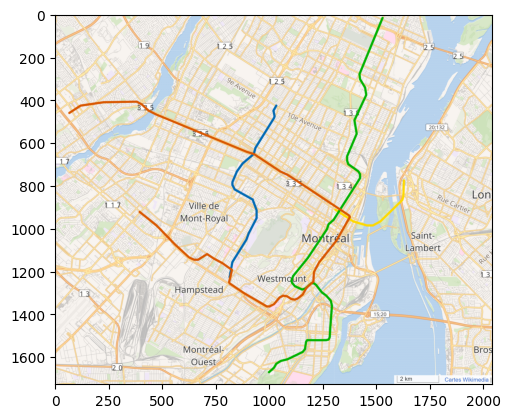

In [ ]:
if not fast_execution:
  I = mping.imread('OpenStreetMap_Montreal.png')
  plt.imshow(I)
  plt.show()

In [ ]:
def revert_coordinates(stations, upmost):
  stations_reverted=[]
  for s in stations:
    stations_reverted.append( [s[0],upmost-s[1] ])

  return stations_reverted

In [ ]:
def plot_heatmap(centr_id_matr, acc_matr, g, all_stations,\
          title, label):

  fig, ax= plt.subplots(figsize=(15, 15))
  im = ax.imshow(acc_matr)
  fig.colorbar(im, ax=ax, shrink=0.5, label=label, format="{x:.1e}")
  ax.set_title(title, fontsize=16)

  for i in range(centr_id_matr.shape[0]):
    for j in range(centr_id_matr.shape[1]):
        text = ax.text(j, i, f'{centr_id_matr[i,j]:.0f}',
                       ha="center", va="center", color="w")
  leftmost, rightmost, bottommost, upmost = g.find_limits()

  stations_rev = revert_coordinates(all_stations, upmost)
  nx.draw(g_lines, stations_rev, with_labels=True,node_color=g.node_color, node_size = g.node_size)



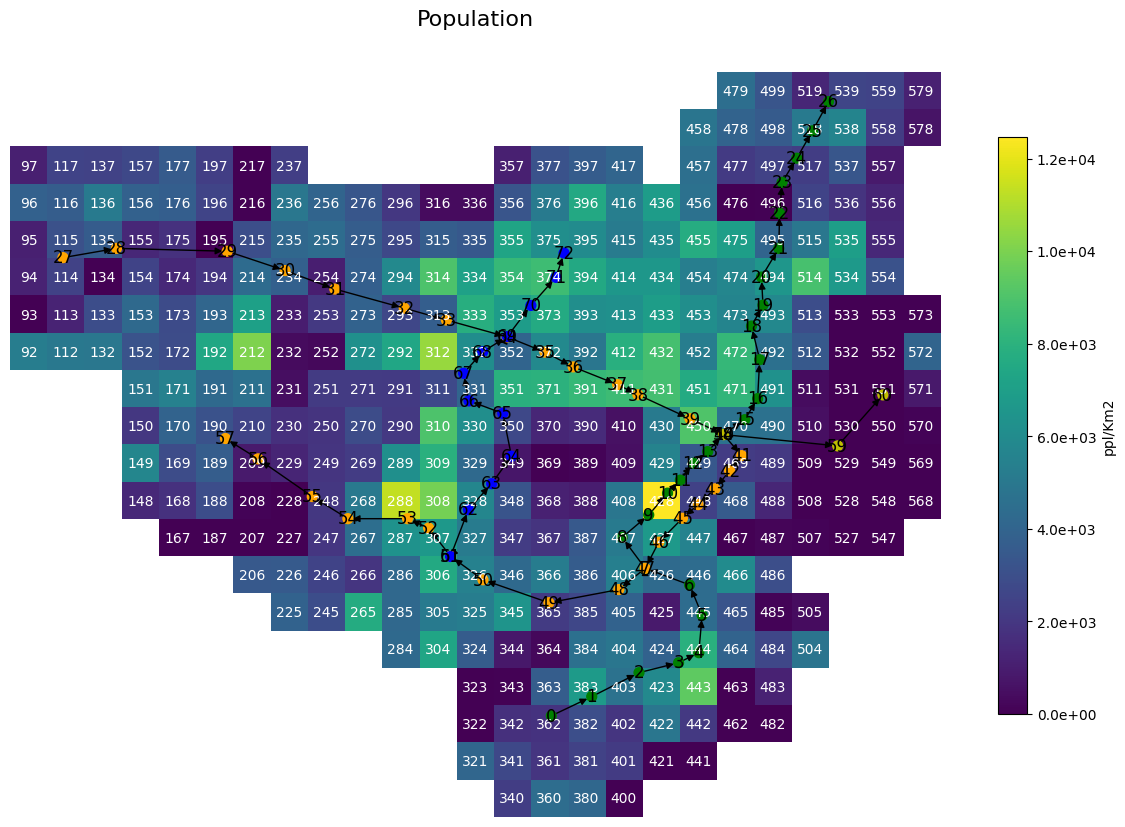

In [ ]:
if not fast_execution:
   plot_heatmap(centr_id_matr, g.pop_matr, g, all_stations, "Population",\
               "ppl/Km2")

In [ ]:
g_lines = nx.DiGraph(list_waiting_time=[], walking_speed=walk_speed)
g_lines.add_nodes_from([i for i in range( len(all_stations) )])
g_lines.add_edges_from(all_edges)

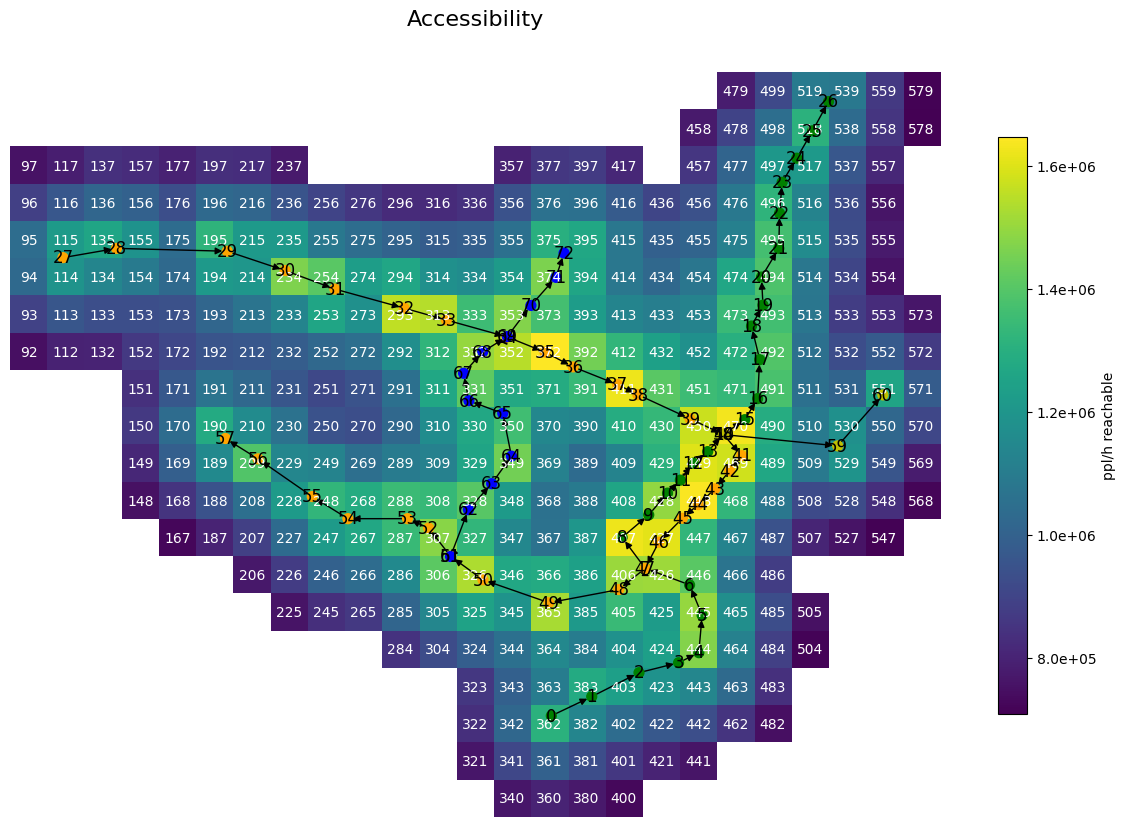

In [ ]:
if not fast_execution:
  plot_heatmap(centr_id_matr, acc_matr_init, g, all_stations, "Accessibility",\
               "ppl/h reachable")

In [ ]:
centroid_population = g.centroid_population
total_population = g.total_population
print(f"total_population={total_population/10**6:.2f} million people")

total_population=1.18 million people


## 2. DRT allocation function definitions

In [ ]:
def find_s1(area,g):
  # Find point "s_1" (see the paper) that is the first point visited by the
  # DRT bus when it enters the area

  s1 = (g.centroid_to_pos[area[4]] + g.centroid_to_pos[area[5]])/2 + np.array([0.5,0])
  return s1

In [ ]:
def findClosestStation(area,g):
    DRT_s_1 = find_s1(area,g)
    distance_station_area_list = []
    for i in g.metro_node:
        metro_pos_i = np.array(g.metro_pos[i])
        distance_station_area_list.append( np.linalg.norm( metro_pos_i - DRT_s_1 ) )

    closest_station = np.argmin( distance_station_area_list )
    return closest_station

In [ ]:
def calculatePho(metro_station_s_A,centroid_i,g, \
        all_pairs_shortest_paht_lengths, all_pair_shortest_paths):
    """
    Calculate what proportion of demands go from centroid_i to somewhere else via metro_station_s_A.
    """

    beta = 0.12
    dest_centroids = []

    #aa: I replaced the previous for-loop with this{
    shortest_paths_from_i_lengths = all_pairs_shortest_paht_lengths.get(centroid_i)
    a = []
    for dest in list(shortest_paths_from_i_lengths.keys()):
       if dest in g.centroid_node and dest != centroid_i:
           dest_centroids.append( dest )
           time_to_dest = shortest_paths_from_i_lengths[dest]
           impedance = np.exp( - beta * time_to_dest  )
           a.append( centroid_population[dest] * impedance)
    a = np.array(a)
    # a is the vector of all importances of all destinations
    ##aa: }

    b = a/np.sum(a)
    c = {}
    for k in range(len(b)):
        dest_centro_id = dest_centroids[k]
        c[dest_centro_id] = b[k]  # if dest_centroids[k] = j, b[k] represents
                            # the proportion of
                            # demand that  go from centroid_i centroid j.

    # vector c has, per each destination, the proportion of demand generated
    # from i that go toward c
    pho = 0.0
    for dest_centroid_id in c:
      if (metro_station_s_A in all_pair_shortest_paths[centroid_i][dest_centroid_id]):
        pho = pho + c[dest_centroid_id]

    t_1 = time.time()
    return pho

In [ ]:
from sympy import solve, symbols


def getHx(n_bus,pho,distance_station_area):
    """
    Solve the system of equations to find the headway of the DRT into an area
    """
    l = 1      #1 km
    h = symbols('h')

    if (not np.isscalar(pho)):
      raise Exception("pho is not a scaler. pho=", pho,". Its type is ", type(pho) )


    h_x = 0
    cycle_time = 0
    #TODO: for the moment, we assume that the DRT demand is symmetric, i.e.,
    #  the demand out (pax using DRT as first mile) = demand in (pax using DRT in their last mile).
    #  This assumption might not be true and should be removed
    h_x = solve( (2*distance_station_area + 6*l*(2*pho*l*l*h)/(2*pho*l*l*h+1)+(2*pho*l*l*h)*l/3+l*4/3)/v_bus + tau_s*(2*pho*l*l*h) + tau_T - n_bus*h  , h)

    print()

    #TODO: Take the smallest postive solution instead of what we do now
    if len(h_x) == 0:
        print('bug h_x no solution!') #TODO: We should rise an exception instead
    elif len(h_x) == 1:
        hx = float(h_x[0])
        #aa: there was a mistake in the line below. the last variable you use
        # in the equation is h and not hx. This was making cycle time be a
        # "symbol", instead of a simple variable, which was messing the entire
        # code. This version of the code is corrected. Notice that I avoid to
        # repeat the same equation again. I only wrote the equation related to
        # cycle time once, at the end of this if-elif-else block
        #cycle_time =  n_bus*hx +  tau_T + tau_s*(2*pho*l*l*h)


        #aa: Moreover, there was also a mistake in the line below (that I now removed).
        # You were returning cycle_length.
        # Compare with meld my getHx and your getHx
        # to get the mistake
    else:
        #print('2 solutions',float(h_x[0]),float(h_x[1]))
        #aa: why we take the max among the two roots. Should not we take
        # the minimum among the positive roots?
        hx = min( float(h_x[0]),float(h_x[1]) )
        if (hx <= 0):
          hx = max( float(h_x[0]),float(h_x[1]) )

    pudos = 2*pho*l*l*hx #number of pickups and dropoffs performed by each bus in a cycle
    cycle_time =  n_bus*hx +  tau_T + tau_s*pudos

    #aa: The following exception helped me in findig the errors above. It is a
    # good idea to keep such Exception, to help us in the future. So, please keep
    # these "raise Exception(..)" here.
    if (not np.isscalar(hx)):
      raise Exception("hx is not a scaler. hx=", hx,\
                      ". Its type is ", type(hx) )

    if (not np.isscalar(cycle_time)):
      raise Exception("cycle_time is not a scaler. cycle_time=", cycle_time,\
                      ". Its type is ", type(cycle_time) )
    #aa: I also return the pudos
    return hx, cycle_time, pudos

In [ ]:
#aa: I renamed "time_alpha" into remaining_fraction_of_cycle
def ingress_or_egress_time(hx,remaining_fraction_of_cycle,n_bus,distance_station_area):
    """
    remaining_fraction_of_cycle: It is a scalar representing the fraction of cycle that is still
              to be done when the DRT bus is at a certain centroid
    """
    # Find ingress_or/egress time for a tile
    #aa: Here you had a hardcoded v_bus=25, which I now removed. I added a
    # constant at the beginning of the notebook
    t = hx/2+ remaining_fraction_of_cycle*(hx*n_bus-2*distance_station_area/v_bus) \
            + distance_station_area/v_bus
    return t

In [ ]:
def compute_fractions_of_remaining_cycle(list_num_services):
  """
    list_num_services: This lists how many pickups and dropoffs occur in each tile
  """
  total_area_demand = np.sum(list_num_services)
  #aa: I had to handle the case where no demand was present, as it
  # was raising an issue
  fractions_of_remaining_cycle = []
  if (total_area_demand == 0):
    raise Exception("Error, total_area_demand must be positive and instead it is zero")


  for i in range(len(list_num_services)):
      if i== len(list_num_services)-1:
        fractions_of_remaining_cycle.append( (list_num_services[i]/2) / total_area_demand )
      else:
        fractions_of_remaining_cycle.append( \
                (list_num_services[i]/2 + np.sum(list_num_services[i+1:])) \
                / total_area_demand )

  if (len(fractions_of_remaining_cycle) != len(list_num_services)):
    raise Exception("len(fraction_of_remaining_cycle)=",len(fractions_of_remaining_cycle),\
                    " and len(list_num_services)=",len(list_num_services),\
                    ". They must be equal instead")
  return fractions_of_remaining_cycle

In [ ]:
def printAllocationInOneArea(area, g, hx, cycle_time, distance_station_area,\
               pudos, dict_centroid_walk_time, t_DRT_dict):

  print(f'Average waiting time={hx*60/2:.1f} min\n Cycle_time {cycle_time*60:.1f} min',\
            f', of which {(distance_station_area/v_bus)*60*2:.1f} min are for going to/from the metro stop;',\
            f'and {(cycle_time - 2*(distance_station_area/v_bus) - tau_T)*60:.1f} min are for circulating inside the area;',\
            f'\nPickups and dropoffs per bus  {pudos:.1f}')
  # Convert to minutes
  dict_centroid_walk_time_min = {}
  t_DRT_dict_min = {}
  for j in dict_centroid_walk_time:
    dict_centroid_walk_time_min[j] = round(dict_centroid_walk_time[j]*60)
  for j in t_DRT_dict:
    t_DRT_dict_min[j] = round(t_DRT_dict[j]*60)

  print(f"Avg walking times to/from stop = {dict_centroid_walk_time_min} min")
  print(f"Avg DRT times to/from stop =     {t_DRT_dict_min} min")

In [ ]:
def assignDRT(n_bus,area,g, assign_iterations):
    """
    area: is [list_of_tiles_belonging_to_an_area]
    Returns:minutes
      valid: if assignment is valid or not
      hx: headway (in hours)
      cycle_time: average time spent by each bus to serve the area (in hours)
    """
    if (assign_iterations <= 1):
      raise Exception ("assign_iterations should be at least 2. You instead ",\
                       "inputted assign_iterations==", assign_iterations)

    # Assign n_bus DRT buses to current worst area worst_.
    #aa: Here you had a hardcoded v_bus=25, which I now removed. I added a
    # constant at the beginning of the notebook
    metro_station = findClosestStation(area,g)
    print("Closest metro station = ", metro_station)

    # Initialize parameters
    valid = False #aa: I added this
    hx = 0
    cycle_time = 0

    #aa: Why do you not have anymore the check for convergence, so as to exit from
    # traffic assignment earlier? This can save you a lot of time.

    DRT_s_1 = find_s1(area,g)
    metro_station_s_A_pos = np.array(g.metro_pos[metro_station])
    distance_station_area = np.linalg.norm( metro_station_s_A_pos - DRT_s_1 )

    #aa: renamed dict_centroid_walk to dict_centroid_walk_time
    dict_centroid_walk_time = {}
    for centroid in area:
        #aa: walk_speed is not hardcoded anymore
        dict_centroid_walk_time[centroid] = \
          np.linalg.norm( metro_station_s_A_pos - g.centroid_to_pos[centroid] )\
                  /walk_speed

    # For the moment we have a maximum limit of assignment iterations because
    # we do all-or-nothing assingment, we in few cases causes the typical
    # instability and we could go on an infinite amount of time
    #TODO: improve traffic assignment
    demand_list_all_steps = []
    centroids_choose_walking = []
    for i in range(assign_iterations):
        print("Assignment iteration",i)
        demand_total = 0.0
        if i < assign_iterations-1:# calculate demand via shortest path
            demand_list = list()
            all_pairs_shortest_paht_lengths =  dict(nx.all_pairs_dijkstra_path_length(g.g))
            all_pair_shortest_paths = dict(nx.all_pairs_dijkstra_path(g.g) )
            for tile in area:
                demand_ = calculatePho(metro_station,tile,g,\
                          all_pairs_shortest_paht_lengths, all_pair_shortest_paths)*\
                          centroid_population[tile]*trip_generation_rate*pt_mode_share  # xxxx demands/km2/hour
                demand_total = demand_total + demand_
                demand_list.append( demand_ )

            demand_list_all_steps.append( demand_list.copy() )
            # At this point demand_list contains all the travelers passing by
            # the stop associated to the area (either walking or using DRT)
        else:# the last itearation, calculate demand by taking average of the demands before
            #aa: It happens sometimes that demand_list_all_steps is empty as in all
            # previous iterations hx has always been 0. In this case, if we do not handle
            # separately, Python will raise an error when calculating
            # np.mean( np.array(demand_list_all_steps)
            if (debug and not demand_list_all_steps):
              raise Exception("The history vector demand_list_all_steps is empty."\
                              "This must not happen")

            demand_list = list( np.mean( np.array(demand_list_all_steps), axis=0 ) )
            demand_total = np.sum( demand_list )


        # At this point, demand_total includes both users using DRT and walking
        hx, cycle_time, pudos = getHx(n_bus,demand_total,distance_station_area)

        if (hx>0): #(otherwise do nothing as the allocation is invalid)
            # An area in map has centroids like in the following order:
                              #{1 3 5}
                              #{0 2 4}
            # the DRT bus runs a cycle by the following order:
            #           metro_station ->s_1-> 5-> 3-> 1-> 0-> 2-> 4 -> s_1 -> metro_station
            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            #aa: I now perform your old computation of alpha_0_list in a separate function
            # Please, conform to this in your code and check if my function implementation
            # is correct
            fractions_of_remaining_cycle = compute_fractions_of_remaining_cycle(phi_i_list)
            list_1 = [fractions_of_remaining_cycle[3],\
                    fractions_of_remaining_cycle[2],fractions_of_remaining_cycle[4],\
                    fractions_of_remaining_cycle[1],fractions_of_remaining_cycle[5],\
                    fractions_of_remaining_cycle[0]]

            # Update demand_list by comparing time cost of walking and DRT
            # We now remove from the demand the traveler flows for which it is
            # better to walk to reach the closest metro station
            centroids_choose_walking = []
            for tile in range(len(area)):
                j = area[tile]
                fraction_of_remaining_cycle = list_1[tile]
                #TODO: Remove the terminal dwell time (see review of TR-A, reviewer 1)
                t_DRT = ingress_or_egress_time(hx,fraction_of_remaining_cycle,n_bus,distance_station_area)
                t_walking = dict_centroid_walk_time[j]
                if t_walking < t_DRT or demand_list[tile]==0:
                    demand_list[tile] = 0.0
                    centroids_choose_walking.append( j )

            total_area_demand = np.sum(demand_list)
            if (debug and total_area_demand == 0 and len(centroids_choose_walking) != len(area)):
              raise Exception("No one is using DRT but there are some tiles in which people "\
                              "do not choose to walk: contradiction")


            hx, cycle_time, pudos = getHx(n_bus,total_area_demand,distance_station_area)

            #demand_list_all_steps.append( demand_list )
            if (total_area_demand != 0):
            #{
              if (debug and demand_list.count(0) != len(centroids_choose_walking)):
                print("Warning: the number of tiles in which the use of DRT is zero ",\
                      "should be equal to the number of centroids where it is faster to ",\
                      "walk than taking DRT. However: demand_list=",demand_list,\
                      " and centroids_choose_walking=",centroids_choose_walking,\
                      ". We are in iteration i=",i)


              #update new alpha from new demand_list

              phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
              #aa: I now perform your old computation of alpha_0_list in a separate function
              # Please, conform to this in your code and check if my function implementation
              # is correct
              fractions_of_remaining_cycle = compute_fractions_of_remaining_cycle(phi_i_list)
              list_1 = [fractions_of_remaining_cycle[3],fractions_of_remaining_cycle[2],\
                      fractions_of_remaining_cycle[4],fractions_of_remaining_cycle[1],\
                      fractions_of_remaining_cycle[5],fractions_of_remaining_cycle[0]]
            #}


            #update ingress/egress time centroid <--> metro station
            t_DRT_dict={}
            for tile in range(len(area)):
                j = area[tile]
                #print('centroid and time',j,  time_alpha*(hx*n_bus-2*distance_station_area/v_bus) + distance_station_area/v_bus)
                if j not in centroids_choose_walking:
                    fraction_of_remaining_cycle = list_1[tile]
                    #TODO: Remove the terminal dwell time (see review of TR-A, reviewer 1)
                    #TODO: Equation t_DRT = ... is repeated twice. It might be
                    # better to transform it in a function and call that function
                    t_DRT = ingress_or_egress_time(hx,fraction_of_remaining_cycle,\
                                                   n_bus,distance_station_area)
                    t_DRT_dict[j] = t_DRT
                    g.add_connection( [(metro_station,j, t_DRT)] )
                    g.add_connection( [(j, metro_station, t_DRT)] )


    #aa: Note that I am printing more information now. It is definitely useful
    # for my class. I don't know if it will be useful for you
    centroids_choosing_DRT = np.setdiff1d(np.array(area), np.array(centroids_choose_walking))
    if (debug):
      print("Centroids for which it is faster to use DRT than walking", centroids_choosing_DRT)

    if (len(area)==len(centroids_choose_walking) and i==assign_iterations-1):
          print ("Invalid allocation of DRT in this area: 0 users will use DRT in area ",\
              area,". This may be due to ",\
             "two factors:\n(i) the number of allocated buses is insufficient or ",\
             "\n(ii) centroids are so close to the associated station that it is always faster ",\
             "to walk to that stop than taking the DRT")
    elif(hx == 0):
      print("Invalid DRT allocation in this area")
    elif(hx*60.0 < minimum_headway):
      print("Error in area ", area,\
          f". Headway is {hx*60:.1f} minutes. This is too short and difficult to ",\
          "operate in reality.\n Headway should be indeed at least ",\
          "2 minutes. Try to allocate less buses")
    else:
      valid = True
      printAllocationInOneArea(area, g, hx, cycle_time, distance_station_area,\
               pudos, dict_centroid_walk_time, t_DRT_dict)

    if not valid:
      raise Exception("There was an error, read the error messages printed above")
    return valid, hx, cycle_time

In [ ]:
def create_area_from_id(area_id):
  area = [area_id, area_id+1, area_id+20, area_id+21, area_id+40, area_id+41]
  valid = True
  j = 0
  while valid and j<len(area):
    if not area[j] in g.centroid_node:
      print("area ",area," is not valid as centroid ",area[j],\
            " is outside the study area")
      valid = False
    j = j+1

  return valid, area

In [ ]:
def allocateDRT(allocation, g):
  allocated_fleet = 0
  for area_id in allocation:
    valid,area = create_area_from_id(area_id)
    if (valid == True):
      num_buses = allocation[area_id]
      print ("\n\nAssigning ",num_buses," buses to area ", area)
      residents = [g.centroid_population[tile] for tile in area ]
      print (f"Residents in the tiles={residents}")

      old_g = copy.deepcopy(g)
      valid_assignment, hx, cycle_time = assignDRT(num_buses,area,g, \
                   assign_iterations=assign_iterations)
      if (valid_assignment):
        allocated_fleet = allocated_fleet + num_buses
      else:
        g= copy.deepcopy(old_g)
    else:
      print("Area ", area_id, " will be ignored")

  print(f"\n\nSuccesfully allocated a fleet of {allocated_fleet} buses")

## 3. The floor is yours!

It's now time to find your own allocation!

The allocation of the fleet of DRT buses should be in the form
`allocation={ area_id:num_buses, ...}`. An example is
```
allocation = {
    92 : 8,
    356: 8
}
```

An area is composed of 3x2 tiles. The id of an area corresponds to the id of the tile at the left-bottom corner of that area. For example, the id of the following area is `363`
```
   364  384  404
   363  383  403
```

You should deploy DRT where accessibility is low and you have enough population that can benefit from your service.

*Suggestion*. It is not worth allocating DRT close to PT stations. Indeed, it is very convenient for users therein to directly walk to PT stations. Therefore, to "convince them" to use DRT you should offer them a super-efficient service, which is competitive to walking, which would require you to deploy too many DRT buses therein.

In [ ]:
allocation = {
    340: 16,
    532: 8
 }


t_0 = time.time()
allocateDRT(allocation, g)
t_1 = time.time()
print(f"\n\nComputation time for assigning DRT: {round(t_1-t_0)} sec")



Assigning  16  buses to area  [340, 341, 360, 361, 380, 381]
Residents in the tiles=[2248, 2699, 4482, 1907, 4154, 2474]
Closest metro station =  0
Assignment iteration 0


Assignment iteration 1


Assignment iteration 2


Assignment iteration 3


Centroids for which it is faster to use DRT than walking [340 341 360 380]
Average waiting time=1.1 min
 Cycle_time 39.2 min , of which 9.0 min are for going to/from the metro stop; and 27.3 min are for circulating inside the area; 
Pickups and dropoffs per bus  9.2
Avg walking times to/from stop = {340: 42, 341: 28, 360: 38, 361: 21, 380: 41, 381: 26} min
Avg DRT times to/from stop =     {340: 24, 341: 28, 360: 17, 380: 9} min


Assigning  8  buses to area  [532, 533, 552, 553, 572, 573]
Residents in the tiles=[0, 0, 0, 0, 4020, 0]
Closest metro station =  60
Assignment iteration 0


Assignment iteration 1


Assignment iteration 2


Assignment iteration 3


Centroids for which it is faster to use DRT than walking [572]
Average waiting time

In [ ]:
centr_id_matr, acc_matr_after = g.build_accessibility_matrix()

#### New accessibility

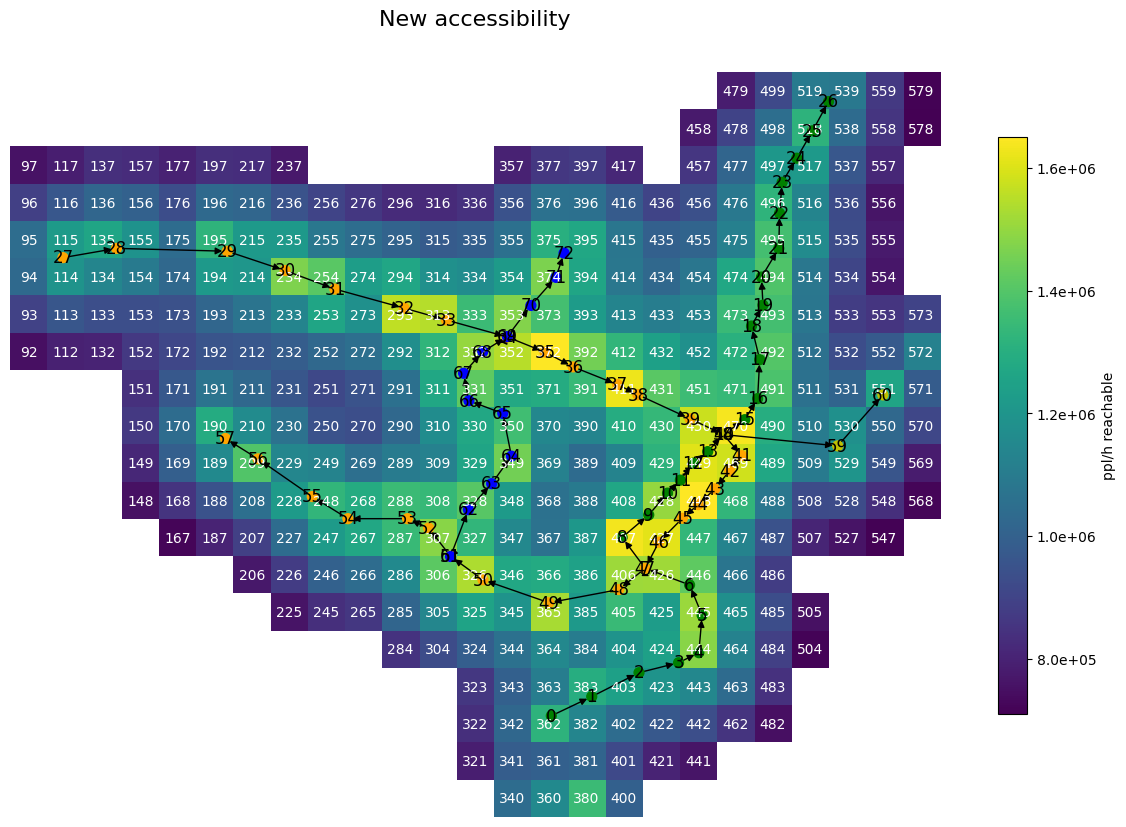

In [ ]:
if not fast_execution:
  plot_heatmap(centr_id_matr, acc_matr_after, g, all_stations, "New accessibility",\
               "ppl/h reachable")

### Improvement

In [ ]:
def print_accessibility_in_DRT_areas(allocation, g, g_init):
  """
  Shows the improvement of accessibility in the areas where DRT was allocated
  """
  for area_id in allocation:
    valid,area = create_area_from_id(area_id)
    print (f"\nAccessibility in area {area}")
    acc_before = [round(g_init.centroid_to_acc[c]/1000) for c in area]
    acc_after =  [round(g.centroid_to_acc[c]/1000) for c in area]
    diff = [ (acc_after[i]-acc_before[i]) for i in range(len(acc_before) ) ]
    print(f"Accessibility before (thousand ppl/h)={acc_before}")
    print(f"Accessibility after (thousand ppl/h)={acc_after}")
    print(f"Improvement (additional thousand ppl/h)={diff}")

print_accessibility_in_DRT_areas(allocation, g, g_init)


Accessibility in area [340, 341, 360, 361, 380, 381]
Accessibility before (thousand ppl/h)=[767, 910, 801, 999, 773, 929]
Accessibility after (thousand ppl/h)=[1044, 988, 1156, 1000, 1350, 1012]
Improvement (additional thousand ppl/h)=[277, 78, 355, 1, 577, 83]

Accessibility in area [532, 533, 552, 553, 572, 573]
Accessibility before (thousand ppl/h)=[932, 881, 975, 826, 873, 765]
Accessibility after (thousand ppl/h)=[934, 883, 978, 857, 1125, 900]
Improvement (additional thousand ppl/h)=[2, 2, 3, 31, 252, 135]


Improvement in accessibility


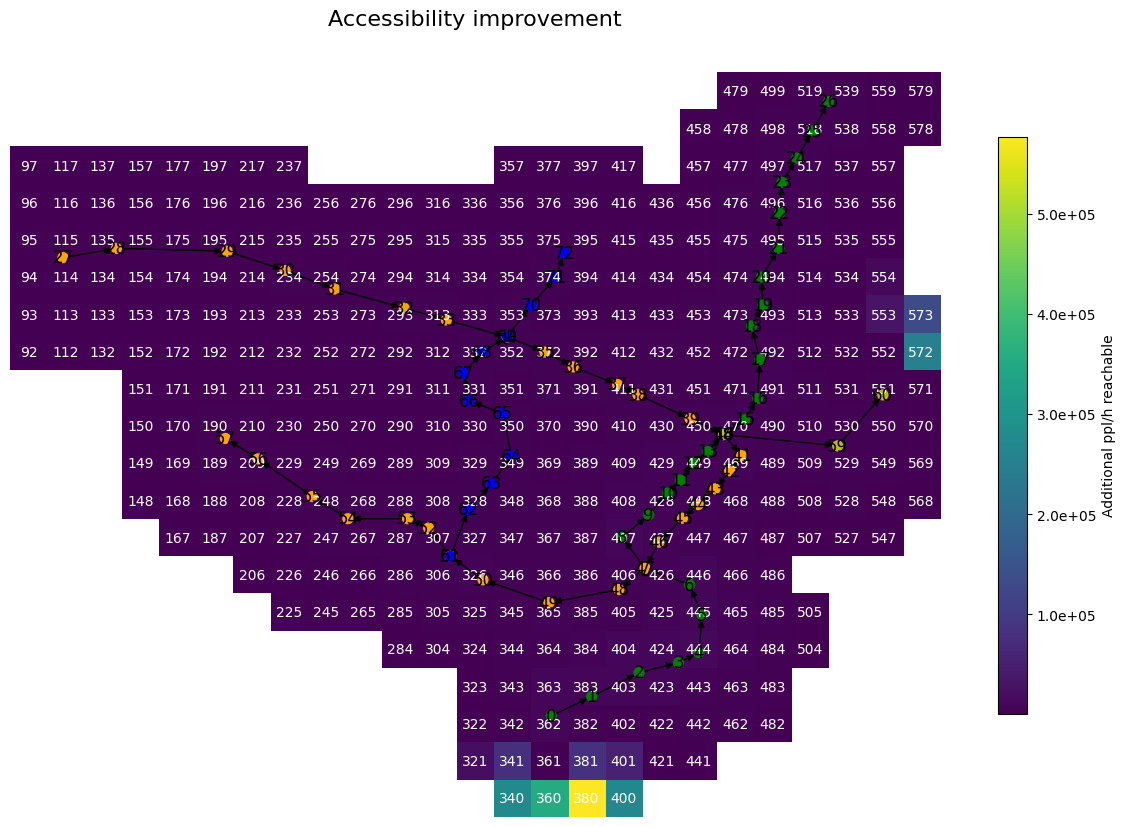

In [ ]:
if not fast_execution:
  diff_matr = acc_matr_after - acc_matr_init
  print("Improvement in accessibility")
  plot_heatmap(centr_id_matr, diff_matr, g, all_stations, "Accessibility improvement",\
               "Additional ppl/h reachable")

In [ ]:
print(f"Gini inequality index: before={g_init.ineq_Gini:.4e}, after={g.ineq_Gini:.4e}")
print(f"Atkinson inequality index: before={g_init.ineq_Atkinson:.4e}, after={g.ineq_Atkinson:.4e}")
print(f"Average individual accessibiltiy before={g_init.avg_acc:.4e} ppl/h, after={g.avg_acc:.4e} ppl/h")
print("DRT fleet:", sum( allocation.values() ) )

Gini inequality index: before=1.1609e-01, after=1.1357e-01
Atkinson inequality index: before=4.0506e-02, after=3.8920e-02
Average individual accessibiltiy before=1.1587e+06 ppl/h, after=1.1670e+06 ppl/h
DRT fleet: 24


In [ ]:
t_1 = time.time()
print(f"Total computation time {t_1-t_begin:.0f} sec")

Total computation time 83 sec
